In [153]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Assumptions
- This challenge should take 5-6 hours to complete
- goal and usd_goal_real are the same column. One is just converted to usd. I ignored the goal column for this reason.

# Introduction

This challenge took me a total of 7 hours to complete. I focused on building simple models in a logical format. This notebook includes the following sections:

    1) Read Data
    2) Data Cleaning
    3) Feature Engineering
    4) EDA
    5) Benchmarking
    6) Model Implementation (LightGBM)
    7) Final Model Implementation
    8) Future Improvements

I spent the most effort on the "Feature Engineering" and "Model Implementation" sections to improve the accuracy of the model as much as possible.

In [152]:
# All import statements
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math
import datetime as dt
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier

import lightgbm as lgb

# 1.0 Read Data

In [2]:
data = pd.read_csv('~/nu_ds_challenge/ml_assignment_data_train.csv')
print('Shape of the dataset is:', data.shape)
data.head(2)

Shape of the dataset is: (258325, 11)


,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26 18:31:19,0,US,8000.00,failed
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27 22:49:51,2,GB,2587.82,failed


# 2.0 Data Cleaning

- Ensure all columns are the correct dtype
    - 'lauched' and 'deadline' column to datetime dtype


In [3]:
data.dtypes

name              object
category          object
main_category     object
currency          object
deadline          object
goal             float64
launched          object
backers            int64
country           object
usd_goal_real    float64
new_state         object
dtype: object

In [4]:
data_v1 = data.assign(
    deadline = pd.to_datetime(pd.to_datetime(data.deadline).dt.date),
    launched = pd.to_datetime(pd.to_datetime(data.launched).dt.date)
)
data_v1.head(2)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,failed
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,failed


- Check for missing values
    - 3 missing values in the name column. Delete these rows as they account for less than 0.1% of the dataset

In [5]:
nulls = pd.DataFrame(data_v1.isnull().sum(), columns=['count_nulls']).sort_values(by=['count_nulls'], ascending=False)
nulls[nulls.count_nulls > 0]

,count_nulls
name,3


In [6]:
# removing rows with missing names
data_v2 = data_v1[data_v1.name.isnull() == False]
print('New shape of dataset is:', data_v2.shape)

New shape of dataset is: (258322, 11)


- Map output variables [failed, succeeded, surged] to [0,1,2]

In [7]:
data_v2['new_state'] = data_v2.new_state.map({'failed':0,'succeeded':1, 'surged':2 })
data_v2.head(2)

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0


- Found an invalid entry for country: 'N,0"'. This only occurs when the main_category and category are the same.
    - Eg: main_category: Music, category: Music
- Remove these rows as they account for less than 0.1% of the dataset

In [8]:
print('Invalid entry for country: N,0"')
print('Number of rows with invalid entry are:', data_v2[data_v2['country'] == 'N,0"'].shape[0])
print()
print('Here are some examples:')
print(data_v2[['category', 'main_category', 'country']][data_v2['country'] == 'N,0"'].head())

Invalid entry for country: N,0"
Number of rows with invalid entry are: 176

Here are some examples:
        category main_category country
105        Music         Music    N,0"
572        Music         Music    N,0"
698   Publishing    Publishing    N,0"
1592       Music         Music    N,0"
7615  Technology    Technology    N,0"


In [9]:
data_v3 = data_v2[data_v2['country'] != 'N,0"']
print('New shape of dataset after deleting rows with invalid entry for country:', data_v3.shape)
data_v3.head(2)

New shape of dataset after deleting rows with invalid entry for country: (258146, 11)


,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0


# 3.0 Feature Engineering

These are the features I came up with:

- For date columns
    - Duration launched in months = deadline - launched (duration the kickstarted was live)
    - Month launched
    - Launch year
    - Deadline year
    - Deadline month
    - Months of active: a column for each month (1 if active, 0 OW)
- For name column
    - len of name
    - number of words in the title
    - Look at the successful or surged titles, remove stop words and make features of the words**(Note: Did not do, maybe for future model improvement)**
- For category columns
    - Concatenating main category and category as a feature (main category-category)
- For usd_goal_real
    - usd_goal_real/backers: number of dollars per backer
    - usd_goal_real/duration_launched_month: number of usd_goal_real needed to earn per month
    - usd_goal_real/duration_launched_month/backers: number of usd_goal_real needed to earn per month per backer
- For backer column
    - backer/duration_launched_month: number of backers per month the kickstarter was live

Implementation of name_length and name_num_words feature

In [10]:
# Name features
data_v3['name_length'] = data_v3.name.apply(lambda x: len(x))
data_v3['name_num_words'] = data_v3.name.apply(lambda x: len(x.split()))
data_v3.head(2)

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0,34,7
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0,29,4


Implementation of duration launched in months, month launched, launch year, deadline year and deadline month

In [11]:
# Date Features
data_v3 = data_v3.assign(
    launch_month = data_v3.launched.dt.month,
    duration_launched_month = ((data_v3.deadline - data_v3.launched)/np.timedelta64(1, 'M')),
    launch_year = data_v3.launched.dt.year,
    deadline_year = data_v3.deadline.dt.year,
    deadline_month = data_v3.deadline.dt.month
)
data_v3.head(2)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0,34,7,10,1.182776,2012,2012,12
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0,29,4,2,1.971293,2017,2017,4


Implementation of usd_goal_per_backer

In [12]:
# Did this feature engineering later so it won't be in knn
# usd_goal_real/backers
data_v3['usd_goal_per_backer'] = np.where(data_v3['backers']>0, 
                                          data_v3['usd_goal_real']/data_v3['backers'],
                                         0)
data_v3.head(2)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month,usd_goal_per_backer
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0,34,7,10,1.182776,2012,2012,12,0.00
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0,29,4,2,1.971293,2017,2017,4,1293.91


Implementation of usd_goal_real/duration of the kickstarter in months and backers per month

In [13]:
# usd_goal_real/duration_launched_month: number of usd_goal_real needed to earn per month
# backer/duration_launched_month: number of backers per month the kickstarter was live
data_v3 = data_v3.assign(
    usd_goal_per_month = data_v3.usd_goal_real/data_v3.duration_launched_month,
    backers_per_month = data_v3.backers/data_v3.duration_launched_month
)
data_v3.head(2)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,...,name_length,name_num_words,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month,usd_goal_per_backer,usd_goal_per_month,backers_per_month
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,...,34,7,10,1.182776,2012,2012,12,0.00,6763.750000,0.000000
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,...,29,4,2,1.971293,2017,2017,4,1293.91,1312.752564,1.014563


Implementation of usd_goal_per_month_per_backer

In [14]:
data_v3['usd_goal_per_month_per_backer'] = np.where(data_v3['backers']>0, 
                                                    ((data_v3['usd_goal_real']/data_v3['duration_launched_month'])
                                                     /data_v3['backers'])
                                                    ,0)
data_v3.head(2)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,...,name_num_words,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month,usd_goal_per_backer,usd_goal_per_month,backers_per_month,usd_goal_per_month_per_backer
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,...,7,10,1.182776,2012,2012,12,0.00,6763.750000,0.000000,0.000000
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,...,4,2,1.971293,2017,2017,4,1293.91,1312.752564,1.014563,656.376282


Implementation of main_category-category

In [15]:
# Concatenating main category and category as a feature
data_v3['main_category-category'] = data_v3[['main_category', 'category']].apply(lambda x: '-'.join(x), axis=1)
data_v3.head(2)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,...,launch_month,duration_launched_month,launch_year,deadline_year,deadline_month,usd_goal_per_backer,usd_goal_per_month,backers_per_month,usd_goal_per_month_per_backer,main_category-category
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,...,10,1.182776,2012,2012,12,0.00,6763.750000,0.000000,0.000000,Publishing-Fiction
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,...,2,1.971293,2017,2017,4,1293.91,1312.752564,1.014563,656.376282,Journalism-Web


Implementation of months active: a column for each month (1 if active, 0 OW) **Left out of the model as it did not add value**

In [16]:
# %%time
# # inputing month cols
# for index, row in data_v3.iterrows():
#     date1 = row['launched']
#     date2 = row['deadline']
    
#     while date1 < date2:
#         data_v3.loc[index, 'month_' + str(date1.month)] = 1
#         date1 += relativedelta(months=1)
# data_v3.head(2)

# 4.0 EDA
**(Note: EDA was done before feature engineering so it may miss some features)**

There are a total of 10 original features in the dataset. I want to do some quick introductory analysis on each of them so I have a good understand of the distrubution of the dataset. 

First Up: new_state

In [109]:
print('These are the classification variables of the dataset', data_v3.new_state.unique())
class_var = pd.DataFrame(data_v3.new_state.value_counts())
class_var = class_var.assign(percent_class = round(class_var.new_state/258322, 2)*100)
print(class_var)

These are the classification variables of the dataset [0 1 2]
   new_state  percent_class
0     158080           61.0
1      66559           26.0
2      33507           13.0


61%, 26% and 13% of the dataset consist of books that failed, succeeded and surged.


Next: usd_goal_real

Following is a histogram of usd_goal_real (taking out 99th percentile)


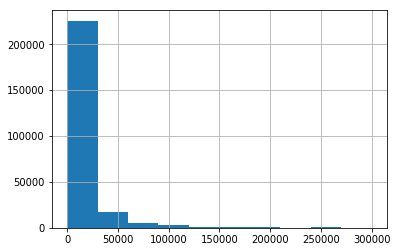

In [110]:
# data_v2.usd_goal_real.hist(bins=10)
print('Following is a histogram of usd_goal_real (taking out 99th percentile)')
data_v3['usd_goal_real'][data_v3['usd_goal_real'] < data_v3['usd_goal_real'].quantile(.99)].hist(bins=10)

Following is a histogram of usd_goal_real less than $50,000


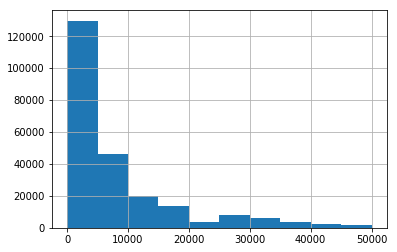

In [111]:
print('Following is a histogram of usd_goal_real less than $50,000')
data_v3['usd_goal_real'][data_v3['usd_goal_real'] < 50000].hist(bins=10)

Based on the histograms above, majority of $ goals are between 0 and 5000

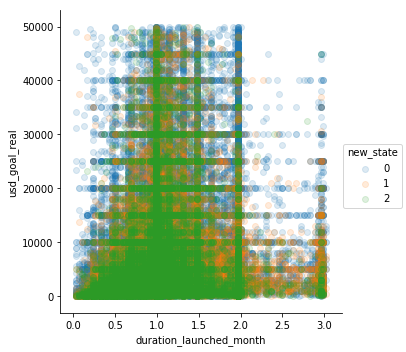

In [112]:
sns.lmplot( x="duration_launched_month", y="usd_goal_real", 
           data=data_v3[(data_v3['usd_goal_real'] < 50000)], 
           fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

There appears to be no correlation between the duration that the kickstarter is live and the goal of the kickstarter.

Next: Currency

There are 14 different currencies in this dataset.
USD    203749
GBP     22930
EUR     11101
CAD      9609
AUD      5082
Name: currency, dtype: int64


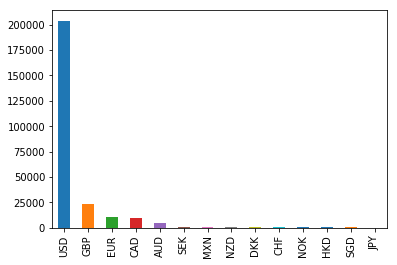

In [113]:
print('There are', data_v3.currency.nunique(), 'different currencies in this dataset.')
print(data_v3.currency.value_counts().head())
data_v3.currency.value_counts().plot(kind="bar")

In the plot above, it is evident that over 75% of the currency in the dataset is USD.


Next: Country

There are 22 different countries in the dataset.
US    203749
GB     22930
CA      9609
AU      5082
DE      2640
Name: country, dtype: int64


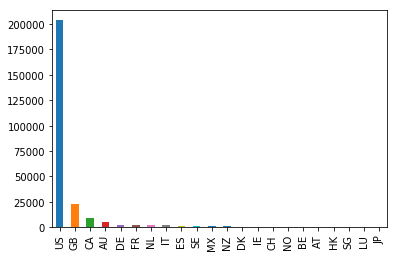

In [114]:
data_v3.country.unique()
print('There are', data_v3.country.nunique(), 'different countries in the dataset.')
print(data_v3.country.value_counts().head())
data_v3.country.value_counts().plot(kind="bar")

The country distribution is similar to the currency distribution.

Next: Names of the Books

In [115]:
data_v3.name.nunique()/data_v3.shape[0]
name_counts = pd.DataFrame(data_v3.name.value_counts())
name_counts[name_counts['name'] > 1].shape

print(name_counts[name_counts['name'] > 1].shape[0], 'books in the dataset have duplicate names.',
     'This is', name_counts['name'][name_counts['name'] > 1].sum(), 
      'total rows in the dataset with duplicate book names (', 
      round((1-(data_v3.name.nunique()/data_v3.shape[0])),2)*100,
     '% of the dataset)')

1072 books in the dataset have duplicate names. This is 2430 total rows in the dataset with duplicate book names ( 1.0 % of the dataset)


Will not use the name of the kickstarter as a feature. Will use the features extracted from the name instead such as length of name.

Next: main_category

There are 15 different main categories.
Here are the the top 5 main categories:
              main_category
Film & Video          44858
Music                 36415
Publishing            28032
Technology            20673
Games                 20630


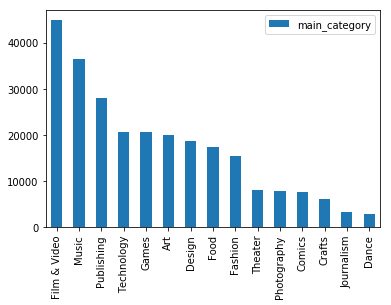

In [119]:
data_v3.main_category.unique()
print('There are', data_v3.main_category.nunique(), 'different main categories.')
main_category_counts = pd.DataFrame(data_v3.main_category.value_counts())
print('Here are the the top 5 main categories:')
print(main_category_counts.head())
main_category_counts.plot.bar()

For unique book names, I do not think it would add much value to one-hot-encode the names as a feature to the model. There are also very few duplicate names. Thus, other features may have to be extracted from the name which will be done in the feature engineering section of the code!


Next: category

There are a total of 159 categories
Here are the top 5 categories:
                category
Product Design     13723
Documentary        11578
Music               9945
Shorts              9035
Food                8303
Following is a bar plot of the top 20 categories:


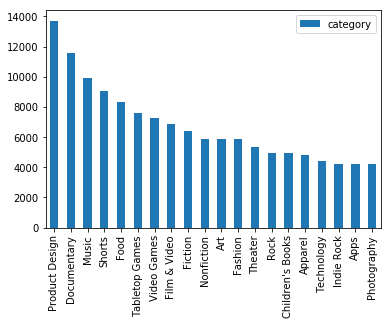

In [120]:
data_v3.category.unique()
print('There are a total of', data_v3.category.nunique(),'categories')
print('Here are the top 5 categories:')
category_counts = pd.DataFrame(data_v3.category.value_counts())
print(category_counts.head())
print('Following is a bar plot of the top 20 categories:')
category_counts.head(20).plot.bar()

Next: launch_year

These are the following counts by year:
   year  count
8  2009    924
7  2010   7619
6  2011  19012
5  2012  30350
4  2013  31946
1  2014  46484
0  2015  50853
2  2016  37861
3  2017  33097


<BarContainer object of 9 artists>

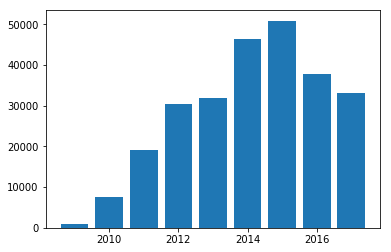

In [24]:
year_counts = (data_v3.launch_year.value_counts()
                    .reset_index()
                    .sort_values(by=['index'], ascending=True)
                    .rename(columns={'index': 'year', 'launch_year': 'count'})
                )
print('These are the following counts by year:')
print(year_counts)
plt.bar(year_counts['year'], year_counts['count'])

There is an increasing trend in the number of kickstarters year over year till 2015 (peak year). After 2015, there is a drop in the number of kickstarters by more tha 10000.

These are the following counts by month:
    month  count
10      1  18878
9       2  20499
1       3  23408
6       4  22210
3       5  22746
4       6  22578
0       7  24975
5       8  22249
8       9  21333
2      10  22779
7      11  22118
11     12  14373


<BarContainer object of 12 artists>

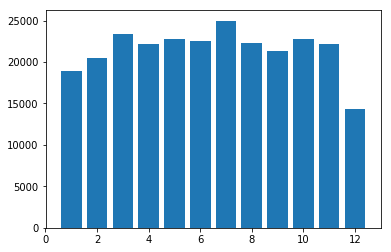

In [26]:
month_counts = (data_v3.launch_month.value_counts()
                    .reset_index()
                    .sort_values(by=['index'], ascending=True)
                    .rename(columns={'index': 'month', 'launch_month': 'count'})
                )
print('These are the following counts by month:')
print(month_counts)
plt.bar(month_counts['month'], month_counts['count'])

December (14373) has the least number of kickstarter projects launched whereas July (24,975) has the most.

Next: backers

In [123]:
data_v3.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'backers', 'country', 'usd_goal_real', 'new_state',
       'name_length', 'name_num_words', 'launch_month',
       'duration_launched_month', 'launch_year', 'deadline_year',
       'deadline_month', 'usd_goal_per_backer', 'usd_goal_per_month',
       'backers_per_month', 'usd_goal_per_month_per_backer',
       'main_category-category'],
      dtype='object')

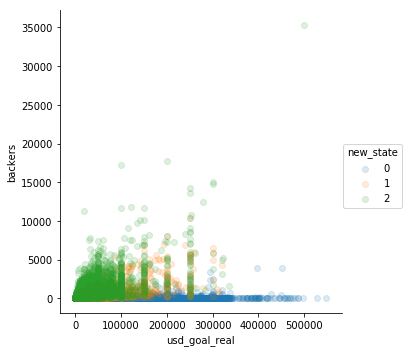

In [124]:
quantile = .99
backers_plot_data = data_v3[data_v3['goal'] < data_v3.goal.quantile(quantile)]
sns.lmplot( x="usd_goal_real", y="backers", 
           data=backers_plot_data, fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

From the plot above, the higher the goal the more likely the kickstarter is to fail. However, if the kickstarter project has a lot of backers, then it is evident to have a higher probability of success.

Next: Applying PCA to numerical data to see if there is separation between the classes

In [148]:
numeric_features = ['goal', 'backers', 'usd_goal_real', 'duration_launched_month', 'usd_goal_per_backer', 
                   'usd_goal_per_month', 'usd_goal_per_month_per_backer',
                   'backers_per_month']

numerical_data = data_v3[numeric_features]
numerical_data = numerical_data[numerical_data['goal'] < numerical_data.goal.quantile(quantile)]

In [149]:
pca = PCA(n_components=2)
scaler = MinMaxScaler()
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns=numerical_data.columns)
pca_data = pca.fit_transform(numerical_data_scaled)
pca_data_df = pd.DataFrame(pca_data, columns=['pca_1', 'pca_2'])

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [150]:
pca_data_df = pd.concat([pca_data_df.reset_index(drop=True), data_v3['new_state'].reset_index(drop=True)], axis=1)
pca_data_df.head(2)

,pca_1,pca_2,new_state
0,0.014921,-0.033079,0
1,0.266832,-0.113595,0


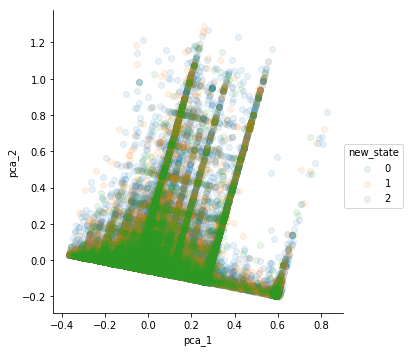

In [151]:
sns.lmplot( x="pca_1", y="pca_2", 
           data=pca_data_df, fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.1})

From the scatter plot of the 2 components, there does not seem to be a clear separation between the classes. 

# 5.0 Benchmarking
I will be using K-nearest neighbors as a benchmark model. K-NN does not usually provide competitive accuracy in comparision to other more complex supervised machine learning algorithms, so it is a good model to compare against.

#### Preprocessing Data for K-NN
Specfic features from the dataset will be picked and scaled using MinMaxScaler for the model. The model will be divided into a train and test set. The best K will be picked using GridSearchcv on the train set. The model will then be implemented on the test set to get the benchmarking metrics.

#### Model Performance
Accuracy and log_loss will be used to evaluate model performance.

## 5.1 K-NN Preprocessing
### Picking Features
I will use the following features for the K-NN model:


'main_category', 'country', 'backers', 'usd_goal_real', 'launch_month', 'launch_year', 'duration_launched_month'

In [54]:
X = data_v3[['main_category', 'country', 'backers', 'usd_goal_real', 'launch_month', 'launch_year',
             'duration_launched_month']]
y = data_v3[['new_state']]
X.head(2)

,main_category,country,backers,usd_goal_real,launch_month,launch_year,duration_launched_month
0,Publishing,US,0,8000.00,10,2012,1.182776
1,Journalism,GB,2,2587.82,2,2017,1.971293


### Preprocessing Features
- one hot encode object features

In [55]:
X_dummies = pd.get_dummies(X)
X_dummies.head(2)

,backers,usd_goal_real,launch_month,launch_year,duration_launched_month,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,8000.00,10,2012,1.182776,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,2587.82,2,2017,1.971293,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- MinMaxScaler on entire set

In [56]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_dummies), columns=X_dummies.columns)
X_scaled.head(2)

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,backers,usd_goal_real,launch_month,launch_year,duration_launched_month,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0.000000,0.000048,0.818182,0.375,0.384615,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000027,0.000016,0.090909,1.000,0.648352,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- change the shape of y
- Split data into training and testing set

In [57]:
y = np.array(y).ravel()
y.shape

(258146,)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
print('Shape of training set is:', X_train.shape)
print('Shape of testing set is:', X_test.shape)

Shape of training set is: (206516, 42)
Shape of testing set is: (51630, 42)


## 5.2 Train K-NN model
- Using gridsearchcv to try out different ranges of k on the training set

In [97]:
knn_model = KNeighborsClassifier()
knn_model_params = {'n_neighbors': np.arange(1,5)}

In [98]:
# %%time
# knn_model_cv = GridSearchCV(knn_model,param_grid=knn_model_params,cv=3, verbose=3)
# knn_model_cv.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=1 ...................................................
[CV] .......... n_neighbors=1, score=0.6553726446592921, total= 2.6min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.0min remaining:    0.0s


[CV] .......... n_neighbors=1, score=0.6568678686525564, total= 2.4min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.2min remaining:    0.0s


[CV] .......... n_neighbors=1, score=0.6546853451404515, total= 2.7min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.6775832534912755, total= 2.8min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.6793542955027146, total= 2.4min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.6777382594178704, total= 2.7min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.6709636210550765, total= 2.7min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.6720523763899776, total= 2.4min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.6711040139362706, total= 2.8min
[CV] n_neighbors=4 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 84.9min finished


CPU times: user 1h 23min 33s, sys: 34.9 s, total: 1h 24min 8s
Wall time: 1h 25min 48s


In [99]:
# print('The best accuracy is:', knn_model_cv.best_score_)
# print('The best k value is:', knn_model_cv.best_params_)

The best score is: 0.6782252718272306
The best k value is: {'n_neighbors': 2}


## 5.3 Testing K-NN model
- apply k-nn model on test set and evaluate the model performance

In [101]:
%%time
knn_test = KNeighborsClassifier()
knn_test.fit(X_train,y_train)
knn_predictions = knn_test.predict(X_test)

CPU times: user 3min 54s, sys: 1.61 s, total: 3min 56s
Wall time: 4min 1s


In [125]:
%%time
knn_prob_predictions = knn_test.predict_proba(X_test)

CPU times: user 2min 48s, sys: 717 ms, total: 2min 49s
Wall time: 2min 50s


In [127]:
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions))
print("Log_loss:",metrics.log_loss(y_test, knn_prob_predictions))

Accuracy: 0.6866156972805575
Log_loss: 3.5592535094921773


## 5.4 Summary of K-NN Results

Will use the accuracy of 68.7% and log loss of 3.56 as a benchmark for the model. These benchmark metrics are credible because if every row in the test dataset was predicted as failed, the accuracy would be approximately 61% (61% of the dataset is labeled as failed).


Let's apply a more sophisticated model to see if we can improve these evalution metrics.

# 6.0 Model Implementation (LightGBM)

I choose boosting for the following reasons:
- Efficient on a large datasets
- Can handle categorical variables without the need for one-hot encoding
- Proven to perform with better results in comparison to Random Forest and SVM and less computation intensive than neural networks
- Very customizable (Lots of parameters available to tune)

## 6.1 Preprocessing Features
- picking features
- changing object features to dtype category
- Split data into train, validation and test set

In [86]:
# numeric_features = ['usd_goal_real', 'backers', 'name_length', 
#                      'name_num_words', 'launch_month', 
#                      'duration_launched_month', 'launch_year','usd_goal_per_backer',
#                    'deadline_year', 'deadline_month']
numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
                   'name_num_words', 'launch_month', 'duration_launched_month',
                   'launch_year', 'usd_goal_per_backer', 'deadline_year', 'deadline_month',
                   'usd_goal_per_month', 'usd_goal_per_month_per_backer',
                   'backers_per_month']
# numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
#        'name_num_words', 'launch_month', 'duration_launched_month',
#        'launch_year', 'deadline_year', 'deadline_month', 'usd_goal_per_backer',
#        'usd_goal_per_month', 'backers_per_month',
#        'usd_goal_per_month_per_backer', 'month_10', 'month_11', 'month_2',
#        'month_3', 'month_4', 'month_8', 'month_6', 'month_7', 'month_5',
#        'month_9', 'month_1', 'month_12']

categorical_features = ['category', 'main_category', 'country', 'main_category-category']
y = data_v3['new_state']

In [87]:
numerical_data = data_v3[numeric_features]
scaler = MinMaxScaler()
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns = numerical_data.columns)

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [88]:
categorical_data = data_v3[categorical_features]
for col in categorical_data.columns: 
     categorical_data[col] = categorical_data[col].astype('category')

print('Changing object variables to categort for lightgbm:')
categorical_data.dtypes

Changing object variables to categort for lightgbm:


/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


category                  category
main_category             category
country                   category
main_category-category    category
dtype: object

In [89]:
X_lgbm = pd.concat([numerical_data_scaled.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)
print('Following are the columns picked for the lightgbm model based on feature importance and trial and error:')
X_lgbm.columns

Following are the columns picked for the lightgbm model based on feature importance and trial and error:


Index(['goal', 'backers', 'usd_goal_real', 'name_length', 'name_num_words',
       'launch_month', 'duration_launched_month', 'launch_year',
       'usd_goal_per_backer', 'deadline_year', 'deadline_month',
       'usd_goal_per_month', 'usd_goal_per_month_per_backer',
       'backers_per_month', 'category', 'main_category', 'country',
       'main_category-category'],
      dtype='object')

In [90]:
X_data, X_test, y_data, y_test = train_test_split(X_lgbm, y, test_size=0.2, random_state=42) #Updated
print('Shape of train set is:', X_data.shape)  
print('Shape of testing set is:', X_test.shape)

Shape of train set is: (206516, 18)
Shape of testing set is: (51630, 18)


## 6.2 Train lightGBM model

In [91]:
def lgbm_model(X_data, y_data, params, n_folds):
    n_folds = KFold(n_splits=n_folds)
    X_data = X_data.reset_index(drop=True)
    y_data = y_data.reset_index(drop=True)

    
    
    train_accuracy = []
    train_loss = []
    validation_accuracy = []
    validation_loss = []
    
    for train_index, validate_index in n_folds.split(X_data):
        
        X_train, X_validate = X_data.iloc[train_index], X_data.iloc[validate_index]
        y_train, y_validate = y_data.iloc[train_index], y_data.iloc[validate_index]
        
        
        lgb_model = lgb.LGBMClassifier(**params, n_jobs=4)
        
        # train the model
        lgb_model.fit(X_train, y_train, early_stopping_rounds=100, 
                      eval_set=(X_validate, y_validate), eval_metric='multi_logloss')

        # get train accuracy and loss
        y_train_pred = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration_)
        y_train_pred_proba = lgb_model.predict_proba(X_train, num_iteration=lgb_model.best_iteration_)

        # get validation accuracy and loss
        y_pred = lgb_model.predict(X_validate, num_iteration=lgb_model.best_iteration_)
        y_pred_proba = lgb_model.predict_proba(X_validate, num_iteration=lgb_model.best_iteration_)

        train_accuracy.append(metrics.accuracy_score(y_train, y_train_pred))
        train_loss.append(metrics.log_loss(y_train, y_train_pred_proba))

        validation_accuracy.append(metrics.accuracy_score(y_validate, y_pred))
        validation_loss.append(metrics.log_loss(y_validate, y_pred_proba))    
    
    
    return [pd.DataFrame(train_accuracy).mean().values[0], 
            pd.DataFrame(train_loss).mean().values[0],
            pd.DataFrame(validation_accuracy).mean().values[0], 
            pd.DataFrame(validation_loss).mean().values[0]], lgb_model

In [92]:
params = {'learning_rate':0.09,
         'boosting_type': 'gbdt',
         'num_class':3,
         'objective':'multiclass',
         'metric': 'multi_logloss',
          'max_depth': 10,
          'reg_alpha': 0.5,
          'reg_lambda': 0.5,
          'n_estimators': 100,
         'num_leaves': 80,
         'min_split_gain': 0.1,
         'min_child_samples': 20}

In [93]:
model_eval, result_model = lgbm_model(X_data, y_data,params,  5)

[1]	valid_0's multi_logloss: 1.00813
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 0.931418
[3]	valid_0's multi_logloss: 0.865311
[4]	valid_0's multi_logloss: 0.808081
[5]	valid_0's multi_logloss: 0.758155
[6]	valid_0's multi_logloss: 0.714279
[7]	valid_0's multi_logloss: 0.675553
[8]	valid_0's multi_logloss: 0.64122
[9]	valid_0's multi_logloss: 0.610725
[10]	valid_0's multi_logloss: 0.583593
[11]	valid_0's multi_logloss: 0.559347
[12]	valid_0's multi_logloss: 0.537726
[13]	valid_0's multi_logloss: 0.518238
[14]	valid_0's multi_logloss: 0.50076
[15]	valid_0's multi_logloss: 0.485018
[16]	valid_0's multi_logloss: 0.470863
[17]	valid_0's multi_logloss: 0.458074
[18]	valid_0's multi_logloss: 0.446536
[19]	valid_0's multi_logloss: 0.436165
[20]	valid_0's multi_logloss: 0.426732
[21]	valid_0's multi_logloss: 0.418237
[22]	valid_0's multi_logloss: 0.410533
[23]	valid_0's multi_logloss: 0.403516
[24]	valid_0's multi_logloss: 0.397148
[25]	valid_0'

[7]	valid_0's multi_logloss: 0.676102
[8]	valid_0's multi_logloss: 0.641746
[9]	valid_0's multi_logloss: 0.611273
[10]	valid_0's multi_logloss: 0.584138
[11]	valid_0's multi_logloss: 0.559848
[12]	valid_0's multi_logloss: 0.538168
[13]	valid_0's multi_logloss: 0.518734
[14]	valid_0's multi_logloss: 0.501216
[15]	valid_0's multi_logloss: 0.485579
[16]	valid_0's multi_logloss: 0.471429
[17]	valid_0's multi_logloss: 0.458641
[18]	valid_0's multi_logloss: 0.447153
[19]	valid_0's multi_logloss: 0.436729
[20]	valid_0's multi_logloss: 0.427251
[21]	valid_0's multi_logloss: 0.418741
[22]	valid_0's multi_logloss: 0.411025
[23]	valid_0's multi_logloss: 0.404029
[24]	valid_0's multi_logloss: 0.397673
[25]	valid_0's multi_logloss: 0.391893
[26]	valid_0's multi_logloss: 0.386637
[27]	valid_0's multi_logloss: 0.381899
[28]	valid_0's multi_logloss: 0.377569
[29]	valid_0's multi_logloss: 0.373622
[30]	valid_0's multi_logloss: 0.369994
[31]	valid_0's multi_logloss: 0.366694
[32]	valid_0's multi_logloss

[11]	valid_0's multi_logloss: 0.561906
[12]	valid_0's multi_logloss: 0.540316
[13]	valid_0's multi_logloss: 0.52099
[14]	valid_0's multi_logloss: 0.503601
[15]	valid_0's multi_logloss: 0.48795
[16]	valid_0's multi_logloss: 0.473824
[17]	valid_0's multi_logloss: 0.461081
[18]	valid_0's multi_logloss: 0.449598
[19]	valid_0's multi_logloss: 0.439244
[20]	valid_0's multi_logloss: 0.429915
[21]	valid_0's multi_logloss: 0.421388
[22]	valid_0's multi_logloss: 0.413707
[23]	valid_0's multi_logloss: 0.406774
[24]	valid_0's multi_logloss: 0.400461
[25]	valid_0's multi_logloss: 0.394737
[26]	valid_0's multi_logloss: 0.38947
[27]	valid_0's multi_logloss: 0.384686
[28]	valid_0's multi_logloss: 0.380372
[29]	valid_0's multi_logloss: 0.376447
[30]	valid_0's multi_logloss: 0.37287
[31]	valid_0's multi_logloss: 0.36959
[32]	valid_0's multi_logloss: 0.366618
[33]	valid_0's multi_logloss: 0.363882
[34]	valid_0's multi_logloss: 0.361397
[35]	valid_0's multi_logloss: 0.359142
[36]	valid_0's multi_logloss: 

## 6.3 Model Results

In [94]:
print("Train Accuracy:",model_eval[0])
print("Train Log_loss:",model_eval[1])
print()
print("Validation Accuracy:",model_eval[2])
print("Validation Log_loss:",model_eval[3])

Train Accuracy: 0.8782600378891736
Train Log_loss: 0.28982670419187245

Validation Accuracy: 0.8605919028391948
Validation Log_loss: 0.33349248999680403


Following is the feature importance bar plot:


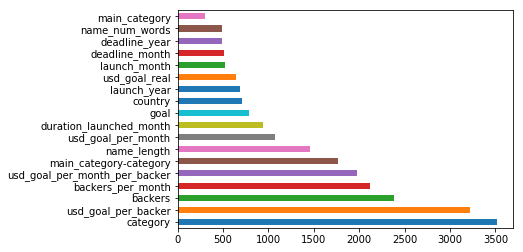

In [95]:
print('Following is the feature importance bar plot:')
(pd.Series(result_model.feature_importances_, index=X_lgbm.columns)
   .nlargest(40)
   .plot(kind='barh')) 

In [85]:
y_pred = result_model.predict(X_test, num_iteration=result_model.best_iteration_)
y_pred_proba = result_model.predict_proba(X_test, num_iteration=result_model.best_iteration_)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Test Log_loss:",metrics.log_loss(y_test, y_pred_proba))

Test Accuracy: 0.852411388727484
Test Log_loss: 0.35307650325890827


In [38]:
cm = confusion_matrix(y_test, y_pred)
accuracy_per_class = pd.DataFrame(((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal())*100,
                                 index=['failed', 'succeeded', 'surged'], columns=['accuracy_per_class'])
print('Following is the accuracy per class for validation set:')
accuracy_per_class

Following is the accuracy per class for validation set:


,accuracy_per_class
failed,94.624705
succeeded,79.427182
surged,59.459056


In [39]:
print('Following is the confusion matrix for the validation set:')
cm_df = pd.DataFrame(((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]))*100, index=['actual_failed', 'actual_succeeded', 'actual_surged'],
            columns=['predicted_failed', 'predicted_succeeded', 'predicted_surged'])
cm_df

Following is the confusion matrix for the validation set:


,predicted_failed,predicted_succeeded,predicted_surged
actual_failed,94.624705,5.022817,0.352478
actual_succeeded,11.198055,79.427182,9.374763
actual_surged,2.898984,37.641961,59.459056


## 6.4 Summary of Model Results
The highest accuracy of the test model on the testing data was ~86%. Model does not overfit as train, validation and test accuracys are ~87%, ~86% and ~86%.

## 6.5 Test out model w SMOTE (Oversampling)

In an attempt to boost accuracy, I want to try oversampling classes that are less represented in the dataset. I hypthesize that this may cause some overfitting in the model as I will only oversample in the train set, however, it may boost the accuracy of the model via lightGBM


SMOTE only works with numerical data. So I will only using numerical features to understand if it makes a difference in the accuracy

I have tried two approaches to oversampling. However, the code only shows the second approach as I deleted the code for the second. Here are the approaches:


**1)** Over sampling only the surged rows in the training data. I oversampled the surged rows in the training set from 26,818 to 50,000. This increased the accuracy of the training dataset from ~86% to ~88%. But, the testing accuracy dropped to ~83%.

**2)** Over sampling all rows and classes. Training dataset grew from 206,516 to 378,915. The training and testing accuracy reduced from ~87% and ~87% to ~82% and ~83%.

In [41]:
numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
                   'name_num_words', 'launch_month', 'duration_launched_month',
                   'launch_year', 'usd_goal_per_backer', 'deadline_year', 'deadline_month',
                   'usd_goal_per_month', 'usd_goal_per_month_per_backer',
                   'backers_per_month']

y = data_v3['new_state']
numerical_data = data_v3[numeric_features]
scaler = MinMaxScaler()
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns = numerical_data.columns)

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [42]:
X_data, X_test, y_data, y_test = train_test_split(numerical_data_scaled, y, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_data.shape)  
print('Shape of testing set is:', X_test.shape)

Shape of train & validation set is: (206516, 14)
Shape of testing set is: (51630, 14)


### 6.5.1 Apply SMOTE on train set

In [43]:
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_data, y_data)
os_data_X = pd.DataFrame(data=os_data_X,columns=X_data.columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['new_state'])

# we can Check the numbers of our data
print("Number of rows of oversampled data is ",len(os_data_X))
print('The numbe of rows that have failed, succeeded and surged as class variables are all 126305. View the value counts of the class variable:')
os_data_y['new_state'].value_counts()

Number of rows of oversampled data is  378915
The numbe of rows that have failed, succeeded and surged as class variables are all 101009. View the value counts of the class variable:


2    126305
1    126305
0    126305
Name: new_state, dtype: int64

### 6.5.2 Train lightGBM model with SMOTE data

In [65]:
def lgbm_model_smote(X_data, y_data, n_folds, random_state=None):
    n_folds = KFold(n_splits=n_folds, random_state=random_state)
    X_data = X_data.reset_index(drop=True)
    y_data = y_data.reset_index(drop=True)

    params = {'learning_rate':0.09,
         'boosting_type': 'gbdt',
         'num_class':3,
         'objective':'multiclass',
         'metric': 'multi_logloss',
          'max_depth': 10,
          'reg_alpha': 0.5,
          'reg_lambda': 0.5,
          'n_estimators': 100,
         'num_leaves': 80,
         'min_split_gain': 0.1,
         'min_child_samples': 20}
    
    train_accuracy = []
    train_loss = []
    validation_accuracy = []
    validation_loss = []
    
    for train_index, validate_index in n_folds.split(X_data):
        
        X_train, X_validate = X_data.iloc[train_index], X_data.iloc[validate_index]
        y_train, y_validate = y_data.iloc[train_index], y_data.iloc[validate_index]
        
        
        lgb_model = lgb.LGBMClassifier(**params, n_jobs=4)
        
        # train the model
        lgb_model.fit(X_train, y_train, early_stopping_rounds=100, 
                      eval_set=(X_validate, y_validate), eval_metric='multi_logloss')

        # get train accuracy and loss
        y_train_pred = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration_)
        y_train_pred_proba = lgb_model.predict_proba(X_train, num_iteration=lgb_model.best_iteration_)

        # get validation accuracy and loss
        y_pred = lgb_model.predict(X_validate, num_iteration=lgb_model.best_iteration_)
        y_pred_proba = lgb_model.predict_proba(X_validate, num_iteration=lgb_model.best_iteration_)

        train_accuracy.append(metrics.accuracy_score(y_train, y_train_pred))

        validation_accuracy.append(metrics.accuracy_score(y_validate, y_pred))   
    
    
    return [pd.DataFrame(train_accuracy).mean().values[0], 
            pd.DataFrame(validation_accuracy).mean().values[0]], lgb_model

In [66]:
model_eval, result_model = lgbm_model_smote(os_data_X, os_data_y, 5, random_state=23413)

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's multi_logloss: 1.01362
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 0.941679
[3]	valid_0's multi_logloss: 0.880011
[4]	valid_0's multi_logloss: 0.826811
[5]	valid_0's multi_logloss: 0.780538
[6]	valid_0's multi_logloss: 0.739983
[7]	valid_0's multi_logloss: 0.70436
[8]	valid_0's multi_logloss: 0.672948
[9]	valid_0's multi_logloss: 0.645181
[10]	valid_0's multi_logloss: 0.620503
[11]	valid_0's multi_logloss: 0.598608
[12]	valid_0's multi_logloss: 0.579091
[13]	valid_0's multi_logloss: 0.561693
[14]	valid_0's multi_logloss: 0.546068
[15]	valid_0's multi_logloss: 0.532139
[16]	valid_0's multi_logloss: 0.519678
[17]	valid_0's multi_logloss: 0.508464
[18]	valid_0's multi_logloss: 0.498445
[19]	valid_0's multi_logloss: 0.489361
[20]	valid_0's multi_logloss: 0.481167
[21]	valid_0's multi_logloss: 0.473806
[22]	valid_0's multi_logloss: 0.467163
[23]	valid_0's multi_logloss: 0.46119
[24]	valid_0's multi_logloss: 0.45579
[25]	valid_0's

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's multi_logloss: 1.01341
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 0.941279
[3]	valid_0's multi_logloss: 0.879507
[4]	valid_0's multi_logloss: 0.826139
[5]	valid_0's multi_logloss: 0.779655
[6]	valid_0's multi_logloss: 0.738978
[7]	valid_0's multi_logloss: 0.703199
[8]	valid_0's multi_logloss: 0.67166
[9]	valid_0's multi_logloss: 0.643698
[10]	valid_0's multi_logloss: 0.618925
[11]	valid_0's multi_logloss: 0.596888
[12]	valid_0's multi_logloss: 0.577333
[13]	valid_0's multi_logloss: 0.559873
[14]	valid_0's multi_logloss: 0.544192
[15]	valid_0's multi_logloss: 0.530172
[16]	valid_0's multi_logloss: 0.517646
[17]	valid_0's multi_logloss: 0.506379
[18]	valid_0's multi_logloss: 0.496251
[19]	valid_0's multi_logloss: 0.487167
[20]	valid_0's multi_logloss: 0.478951
[21]	valid_0's multi_logloss: 0.471599
[22]	valid_0's multi_logloss: 0.464945
[23]	valid_0's multi_logloss: 0.458899
[24]	valid_0's multi_logloss: 0.453474
[25]	valid_0

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's multi_logloss: 1.02346
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 0.959492
[3]	valid_0's multi_logloss: 0.904442
[4]	valid_0's multi_logloss: 0.856594
[5]	valid_0's multi_logloss: 0.814913
[6]	valid_0's multi_logloss: 0.778218
[7]	valid_0's multi_logloss: 0.745835
[8]	valid_0's multi_logloss: 0.717192
[9]	valid_0's multi_logloss: 0.691691
[10]	valid_0's multi_logloss: 0.669007
[11]	valid_0's multi_logloss: 0.648761
[12]	valid_0's multi_logloss: 0.630735
[13]	valid_0's multi_logloss: 0.614613
[14]	valid_0's multi_logloss: 0.60011
[15]	valid_0's multi_logloss: 0.58713
[16]	valid_0's multi_logloss: 0.575397
[17]	valid_0's multi_logloss: 0.564827
[18]	valid_0's multi_logloss: 0.555371
[19]	valid_0's multi_logloss: 0.546755
[20]	valid_0's multi_logloss: 0.538915
[21]	valid_0's multi_logloss: 0.531844
[22]	valid_0's multi_logloss: 0.525449
[23]	valid_0's multi_logloss: 0.519627
[24]	valid_0's multi_logloss: 0.514331
[25]	valid_0'

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's multi_logloss: 1.04687
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.00172
[3]	valid_0's multi_logloss: 0.962345
[4]	valid_0's multi_logloss: 0.92774
[5]	valid_0's multi_logloss: 0.897194
[6]	valid_0's multi_logloss: 0.87023
[7]	valid_0's multi_logloss: 0.846156
[8]	valid_0's multi_logloss: 0.824557
[9]	valid_0's multi_logloss: 0.805375
[10]	valid_0's multi_logloss: 0.788465
[11]	valid_0's multi_logloss: 0.773086
[12]	valid_0's multi_logloss: 0.759409
[13]	valid_0's multi_logloss: 0.7467
[14]	valid_0's multi_logloss: 0.735526
[15]	valid_0's multi_logloss: 0.725364
[16]	valid_0's multi_logloss: 0.716197
[17]	valid_0's multi_logloss: 0.707689
[18]	valid_0's multi_logloss: 0.700106
[19]	valid_0's multi_logloss: 0.693131
[20]	valid_0's multi_logloss: 0.68726
[21]	valid_0's multi_logloss: 0.681647
[22]	valid_0's multi_logloss: 0.676456
[23]	valid_0's multi_logloss: 0.671683
[24]	valid_0's multi_logloss: 0.6675
[25]	valid_0's mult

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's multi_logloss: 1.06038
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.02916
[3]	valid_0's multi_logloss: 1.00313
[4]	valid_0's multi_logloss: 0.981492
[5]	valid_0's multi_logloss: 0.963749
[6]	valid_0's multi_logloss: 0.948902
[7]	valid_0's multi_logloss: 0.936275
[8]	valid_0's multi_logloss: 0.925798
[9]	valid_0's multi_logloss: 0.917095
[10]	valid_0's multi_logloss: 0.909941
[11]	valid_0's multi_logloss: 0.904138
[12]	valid_0's multi_logloss: 0.89925
[13]	valid_0's multi_logloss: 0.895432
[14]	valid_0's multi_logloss: 0.892259
[15]	valid_0's multi_logloss: 0.8897
[16]	valid_0's multi_logloss: 0.887715
[17]	valid_0's multi_logloss: 0.886217
[18]	valid_0's multi_logloss: 0.885153
[19]	valid_0's multi_logloss: 0.884118
[20]	valid_0's multi_logloss: 0.883538
[21]	valid_0's multi_logloss: 0.882955
[22]	valid_0's multi_logloss: 0.882545
[23]	valid_0's multi_logloss: 0.882202
[24]	valid_0's multi_logloss: 0.882126
[25]	valid_0's m

### 6.5.3 Evaluation of Model w SMOTE Results

In [72]:
print("Train Accuracy:",model_eval[0])
print()
y_pred = result_model.predict(X_test, num_iteration=result_model.best_iteration_)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

Train Accuracy: 0.8306737658841692

Test Accuracy: 0.8484795661437149


Following is the feature importance bar plot:


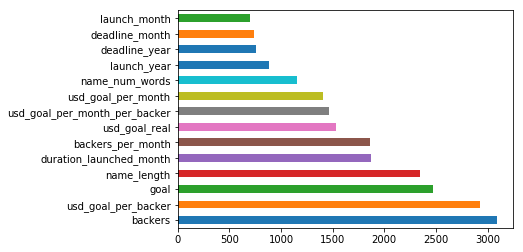

In [68]:
print('Following is the feature importance bar plot:')
(pd.Series(result_model.feature_importances_, index=numerical_data_scaled.columns)
   .nlargest(40)
   .plot(kind='barh')) 

In [70]:
cm = confusion_matrix(y_test, y_pred)
accuracy_per_class = pd.DataFrame(((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal())*100,
                                 index=['failed', 'succeeded', 'surged'], columns=['accuracy_per_class'])
print('Following is the accuracy per class for validation set:')
accuracy_per_class

Following is the accuracy per class for validation set:


,accuracy_per_class
failed,91.647522
succeeded,82.298868
surged,57.576210


In [71]:
print('Following is the confusion matrix for the validation set:')
cm_df = pd.DataFrame(((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]))*100, index=['actual_failed', 'actual_succeeded', 'actual_surged'],
            columns=['predicted_failed', 'predicted_succeeded', 'predicted_surged'])
cm_df

Following is the confusion matrix for the validation set:


,predicted_failed,predicted_succeeded,predicted_surged
actual_failed,91.647522,8.119591,0.232887
actual_succeeded,8.182025,82.298868,9.519107
actual_surged,1.823072,40.600717,57.576210


Test Accuracy: 0.8484795661437149


### 6.5.4 Summary of Test Model w SMOTE
I will summarize by approach:

1) The first approach increased the training accuracy from ~87% to ~89%. However, the validation and test accuracy lowered to ~85%

2) The second approach reduced the trainand test accuracy to ~83% and ~84%. SMOTE will not be used in the final model.

## 6.6 Parameter Tuning for Test Model via Bayesian Optimization

In [155]:
numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
                   'name_num_words', 'launch_month', 'duration_launched_month',
                   'launch_year', 'usd_goal_per_backer', 'deadline_year', 'deadline_month',
                   'usd_goal_per_month', 'usd_goal_per_month_per_backer',
                   'backers_per_month']

categorical_features = ['category', 'main_category', 'country', 'main_category-category']
y = data_v3['new_state']

In [154]:
y_pred = lgb_model_v2.predict(X_test, num_iteration=lgb_model_v2.best_iteration_)
y_pred_proba = lgb_model_v2.predict_proba(X_test, num_iteration=lgb_model_v2.best_iteration_)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Test Log_loss:",metrics.log_loss(y_test, y_pred_proba))

Test Accuracy: 0.8408677125702111
Test Log_loss: 0.3753615477963626


In [156]:
numerical_data = data_v3[numeric_features]
scaler = MinMaxScaler()
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns = numerical_data.columns)

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [157]:
categorical_data = data_v3[categorical_features]
for col in categorical_data.columns: 
     categorical_data[col] = categorical_data[col].astype('category')

categorical_data.dtypes

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


category                  category
main_category             category
country                   category
main_category-category    category
dtype: object

In [158]:
X_lgbm = pd.concat([numerical_data_scaled.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)

In [159]:
X_data, X_test, y_data, y_test = train_test_split(X_lgbm, y, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_data.shape)  
print('Shape of testing set is:', X_test.shape)

Shape of train & validation set is: (206516, 18)
Shape of testing set is: (51630, 18)


In [160]:
X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_train.shape)  
print('Shape of testing set is:', X_validate.shape)

Shape of train & validation set is: (165212, 18)
Shape of testing set is: (41304, 18)


In [161]:
def bayes_parameter_opt_lgb(X_train, y_train, X_validate, y_validate, init_round=1, opt_round=1):
    
    def lgb_apply(learning_rate, num_leaves, n_estimators, max_depth, 
                  lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        
        params = {'boosting_type': 'gbdt', 'objective':'multiclass', 'num_class':3}
        params["learning_rate"] = learning_rate
        params["num_leaves"] = int(round(num_leaves))
        params["n_estimators"] = int(math.ceil(n_estimators/100)) * 100
        params['max_depth'] = int(round(max_depth))
        params['reg_alpha'] = max(lambda_l1, 0)
        params['reg_lambda'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = int(math.ceil(min_child_weight/100)) * 100
        
        lgb_model = lgb.LGBMClassifier(**params, n_jobs=4)
        lgb_model.fit(X_train, y_train, early_stopping_rounds=200, 
                      eval_set=(X_test, y_test), 
                      eval_metric='multi_logloss')
        
        y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)
        
        return metrics.accuracy_score(y_test, y_pred)
    
    
    lgb_bayesian_params = BayesianOptimization(lgb_apply, pbounds={'learning_rate': (0.1, 0.9), 
                                                       'n_estimators': (400,1000), 
                                                       'num_leaves': (400, 1000),
                                                       'max_depth': (60, 100),
                                                       'lambda_l1': (0.1, 1.0),
                                                       'lambda_l2': (0.1, 4.0),
                                                       'min_split_gain': (0.1, 0.4),
                                                       'min_child_weight': (200,500)})
    
    lgb_bayesian_params.maximize(init_points=int(init_round), n_iter=int(opt_round))
#     lgb_bayesian_params.to_csv("~/data/bayes_opt_result.csv")
    return lgb_bayesian_params
#     return lgb_bayesian_params.res['max']['max_params']
    

In [162]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, X_validate, y_validate, init_round=1, opt_round=1)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   lambda_l1 |   lambda_l2 |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   n_estimators |   num_leaves | 
[1]	valid_0's multi_logloss: 0.544274	valid_0's multi_logloss: 0.544274
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 0.419088	valid_0's multi_logloss: 0.419088
[3]	valid_0's multi_logloss: 0.370757	valid_0's multi_logloss: 0.370757
[4]	valid_0's multi_logloss: 0.350347	valid_0's multi_logloss: 0.350347
[5]	valid_0's multi_logloss: 0.341104	valid_0's multi_logloss: 0.341104
[6]	valid_0's multi_logloss: 0.337107	valid_0's multi_logloss: 0.337107
[7]	valid_0's multi_logloss: 0.335541	valid_0's multi_logloss: 0.335541
[8]	valid_0's multi_logloss: 0.334605	valid_0's multi_logloss: 0.334605
[9]	valid_0's multi_l

[112]	valid_0's multi_logloss: 0.350241	valid_0's multi_logloss: 0.350241
[113]	valid_0's multi_logloss: 0.350443	valid_0's multi_logloss: 0.350443
[114]	valid_0's multi_logloss: 0.350399	valid_0's multi_logloss: 0.350399
[115]	valid_0's multi_logloss: 0.350669	valid_0's multi_logloss: 0.350669
[116]	valid_0's multi_logloss: 0.350746	valid_0's multi_logloss: 0.350746
[117]	valid_0's multi_logloss: 0.350929	valid_0's multi_logloss: 0.350929
[118]	valid_0's multi_logloss: 0.351011	valid_0's multi_logloss: 0.351011
[119]	valid_0's multi_logloss: 0.35116	valid_0's multi_logloss: 0.35116
[120]	valid_0's multi_logloss: 0.351344	valid_0's multi_logloss: 0.351344
[121]	valid_0's multi_logloss: 0.351541	valid_0's multi_logloss: 0.351541
[122]	valid_0's multi_logloss: 0.351732	valid_0's multi_logloss: 0.351732
[123]	valid_0's multi_logloss: 0.35184	valid_0's multi_logloss: 0.35184
[124]	valid_0's multi_logloss: 0.352062	valid_0's multi_logloss: 0.352062
[125]	valid_0's multi_logloss: 0.352108	va

[6]	valid_0's multi_logloss: 0.336385	valid_0's multi_logloss: 0.336385
[7]	valid_0's multi_logloss: 0.335547	valid_0's multi_logloss: 0.335547
[8]	valid_0's multi_logloss: 0.335388	valid_0's multi_logloss: 0.335388
[9]	valid_0's multi_logloss: 0.335055	valid_0's multi_logloss: 0.335055
[10]	valid_0's multi_logloss: 0.335145	valid_0's multi_logloss: 0.335145
[11]	valid_0's multi_logloss: 0.334957	valid_0's multi_logloss: 0.334957
[12]	valid_0's multi_logloss: 0.334864	valid_0's multi_logloss: 0.334864
[13]	valid_0's multi_logloss: 0.334969	valid_0's multi_logloss: 0.334969
[14]	valid_0's multi_logloss: 0.335182	valid_0's multi_logloss: 0.335182
[15]	valid_0's multi_logloss: 0.335523	valid_0's multi_logloss: 0.335523
[16]	valid_0's multi_logloss: 0.335531	valid_0's multi_logloss: 0.335531
[17]	valid_0's multi_logloss: 0.335371	valid_0's multi_logloss: 0.335371
[18]	valid_0's multi_logloss: 0.335497	valid_0's multi_logloss: 0.335497
[19]	valid_0's multi_logloss: 0.335715	valid_0's multi_

[121]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[122]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[123]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[124]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[125]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[126]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[127]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[128]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[129]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[130]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[131]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[132]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[133]	valid_0's multi_logloss: 0.339164	valid_0's multi_logloss: 0.339164
[134]	valid_0's multi_logloss: 0.33916

In [163]:
opt_params.res['max']

{'max_val': 0.8606817741623087,
 'max_params': {'learning_rate': 0.8452193147776897,
  'n_estimators': 975.2053168635805,
  'num_leaves': 512.281120492506,
  'max_depth': 96.68159655124637,
  'lambda_l1': 0.6359469388237938,
  'lambda_l2': 1.5989495850645994,
  'min_split_gain': 0.3270589793835691,
  'min_child_weight': 382.14300153947573}}

In [ ]:
# 0.8627348440828976
# {'learning_rate': 0.1386500136508193,
#  'n_estimators': 358.05178999366126,
#  'num_leaves': 411.83694928592564,
#  'max_depth': 58.410142023835064,
#  'lambda_l1': 0.9946285477898449,
#  'lambda_l2': 3.6479877739422446,
#  'min_split_gain': 0.3772608807213311,
#  'min_child_weight': 193.91574405974183}


# {'max_val': 0.863257795855123,
#  'max_params': {'learning_rate': 0.27201596157942154,
#   'n_estimators': 993.3688372520834,
#   'num_leaves': 574.7187524038648,
#   'max_depth': 62.488789829408745,
#   'lambda_l1': 0.3493254134565104,
#   'lambda_l2': 0.10893183989673129,
#   'min_split_gain': 0.2238516674953104,
#   'min_child_weight': 359.24528857050746}}

## 7.0 Final LightGBM Model Implementation

In [96]:
# numeric_features = ['usd_goal_real', 'backers', 'name_length', 
#                      'name_num_words', 'launch_month', 
#                      'duration_launched_month', 'launch_year','usd_goal_per_backer',
#                    'deadline_year', 'deadline_month']
numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
                   'name_num_words', 'launch_month', 'duration_launched_month',
                   'launch_year', 'usd_goal_per_backer', 'deadline_year', 'deadline_month',
                   'usd_goal_per_month', 'usd_goal_per_month_per_backer',
                   'backers_per_month']
# numeric_features = ['goal', 'backers', 'usd_goal_real', 'name_length',
#        'name_num_words', 'launch_month', 'duration_launched_month',
#        'launch_year', 'deadline_year', 'deadline_month', 'usd_goal_per_backer',
#        'usd_goal_per_month', 'backers_per_month',
#        'usd_goal_per_month_per_backer', 'month_10', 'month_11', 'month_2',
#        'month_3', 'month_4', 'month_8', 'month_6', 'month_7', 'month_5',
#        'month_9', 'month_1', 'month_12']

categorical_features = ['category', 'main_category', 'country', 'main_category-category']
y = data_v3['new_state']

In [97]:
numerical_data = data_v3[numeric_features]
scaler = MinMaxScaler()
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns = numerical_data.columns)

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [98]:
categorical_data = data_v3[categorical_features]
for col in categorical_data.columns: 
     categorical_data[col] = categorical_data[col].astype('category')

categorical_data.dtypes

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


category                  category
main_category             category
country                   category
main_category-category    category
dtype: object

In [99]:
X_lgbm = pd.concat([numerical_data_scaled.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)

In [100]:
print('Following columns are used in the final model:')
X_lgbm.columns

Following columns are used in the final model:


Index(['goal', 'backers', 'usd_goal_real', 'name_length', 'name_num_words',
       'launch_month', 'duration_launched_month', 'launch_year',
       'usd_goal_per_backer', 'deadline_year', 'deadline_month',
       'usd_goal_per_month', 'usd_goal_per_month_per_backer',
       'backers_per_month', 'category', 'main_category', 'country',
       'main_category-category'],
      dtype='object')

In [101]:
X_data, X_test, y_data, y_test = train_test_split(X_lgbm, y, test_size=0.2, random_state=42) #Updated
print('Shape of train & validation set is:', X_data.shape)  
print('Shape of testing set is:', X_test.shape)

Shape of train & validation set is: (206516, 18)
Shape of testing set is: (51630, 18)


In [102]:
params = {'learning_rate':0.272,
         'boosting_type': 'gbdt',
         'num_class':3,
         'objective':'multiclass',
         'metric': 'multi_logloss',
          'max_depth': 10,
          'reg_alpha': 0.349,
          'reg_lambda': 0.109,
          'n_estimators': 1000,
         'num_leaves': 600,
         'min_split_gain': 0.1,
         'min_child_samples': 400}

In [103]:
model_eval, result_model = lgbm_model(X_data, y_data,params,  5)

[1]	valid_0's multi_logloss: 0.845846
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 0.693062
[3]	valid_0's multi_logloss: 0.591943
[4]	valid_0's multi_logloss: 0.521984
[5]	valid_0's multi_logloss: 0.472382
[6]	valid_0's multi_logloss: 0.436494
[7]	valid_0's multi_logloss: 0.410134
[8]	valid_0's multi_logloss: 0.390927
[9]	valid_0's multi_logloss: 0.376595
[10]	valid_0's multi_logloss: 0.365789
[11]	valid_0's multi_logloss: 0.357748
[12]	valid_0's multi_logloss: 0.351537
[13]	valid_0's multi_logloss: 0.346818
[14]	valid_0's multi_logloss: 0.343169
[15]	valid_0's multi_logloss: 0.340413
[16]	valid_0's multi_logloss: 0.338374
[17]	valid_0's multi_logloss: 0.336834
[18]	valid_0's multi_logloss: 0.335597
[19]	valid_0's multi_logloss: 0.334614
[20]	valid_0's multi_logloss: 0.333714
[21]	valid_0's multi_logloss: 0.333121
[22]	valid_0's multi_logloss: 0.332714
[23]	valid_0's multi_logloss: 0.332395
[24]	valid_0's multi_logloss: 0.332153
[25]	valid

[78]	valid_0's multi_logloss: 0.343348
[79]	valid_0's multi_logloss: 0.343497
[80]	valid_0's multi_logloss: 0.343662
[81]	valid_0's multi_logloss: 0.343903
[82]	valid_0's multi_logloss: 0.344043
[83]	valid_0's multi_logloss: 0.344096
[84]	valid_0's multi_logloss: 0.344221
[85]	valid_0's multi_logloss: 0.344381
[86]	valid_0's multi_logloss: 0.344573
[87]	valid_0's multi_logloss: 0.344613
[88]	valid_0's multi_logloss: 0.344745
[89]	valid_0's multi_logloss: 0.344896
[90]	valid_0's multi_logloss: 0.34504
[91]	valid_0's multi_logloss: 0.345155
[92]	valid_0's multi_logloss: 0.345311
[93]	valid_0's multi_logloss: 0.34545
[94]	valid_0's multi_logloss: 0.345579
[95]	valid_0's multi_logloss: 0.345697
[96]	valid_0's multi_logloss: 0.345987
[97]	valid_0's multi_logloss: 0.346054
[98]	valid_0's multi_logloss: 0.34616
[99]	valid_0's multi_logloss: 0.346291
[100]	valid_0's multi_logloss: 0.346364
[101]	valid_0's multi_logloss: 0.34643
[102]	valid_0's multi_logloss: 0.346549
[103]	valid_0's multi_logl

[22]	valid_0's multi_logloss: 0.337023
[23]	valid_0's multi_logloss: 0.336615
[24]	valid_0's multi_logloss: 0.336416
[25]	valid_0's multi_logloss: 0.33618
[26]	valid_0's multi_logloss: 0.335976
[27]	valid_0's multi_logloss: 0.335882
[28]	valid_0's multi_logloss: 0.335883
[29]	valid_0's multi_logloss: 0.335867
[30]	valid_0's multi_logloss: 0.335867
[31]	valid_0's multi_logloss: 0.335845
[32]	valid_0's multi_logloss: 0.33595
[33]	valid_0's multi_logloss: 0.335986
[34]	valid_0's multi_logloss: 0.336048
[35]	valid_0's multi_logloss: 0.336033
[36]	valid_0's multi_logloss: 0.336107
[37]	valid_0's multi_logloss: 0.33627
[38]	valid_0's multi_logloss: 0.336328
[39]	valid_0's multi_logloss: 0.336428
[40]	valid_0's multi_logloss: 0.336605
[41]	valid_0's multi_logloss: 0.336791
[42]	valid_0's multi_logloss: 0.336959
[43]	valid_0's multi_logloss: 0.336965
[44]	valid_0's multi_logloss: 0.337003
[45]	valid_0's multi_logloss: 0.337067
[46]	valid_0's multi_logloss: 0.337134
[47]	valid_0's multi_logloss

[100]	valid_0's multi_logloss: 0.342764
[101]	valid_0's multi_logloss: 0.342942
[102]	valid_0's multi_logloss: 0.34301
[103]	valid_0's multi_logloss: 0.343118
[104]	valid_0's multi_logloss: 0.343309
[105]	valid_0's multi_logloss: 0.343393
[106]	valid_0's multi_logloss: 0.343469
[107]	valid_0's multi_logloss: 0.343544
[108]	valid_0's multi_logloss: 0.3436
[109]	valid_0's multi_logloss: 0.343768
[110]	valid_0's multi_logloss: 0.343899
[111]	valid_0's multi_logloss: 0.343968
[112]	valid_0's multi_logloss: 0.34404
[113]	valid_0's multi_logloss: 0.344098
[114]	valid_0's multi_logloss: 0.344167
[115]	valid_0's multi_logloss: 0.344341
[116]	valid_0's multi_logloss: 0.344397
[117]	valid_0's multi_logloss: 0.344465
[118]	valid_0's multi_logloss: 0.344539
[119]	valid_0's multi_logloss: 0.344668
[120]	valid_0's multi_logloss: 0.344795
[121]	valid_0's multi_logloss: 0.344851
[122]	valid_0's multi_logloss: 0.344976
[123]	valid_0's multi_logloss: 0.345015
[124]	valid_0's multi_logloss: 0.345132
[125

## 7.1 Final Model Results

In [104]:
print("Train Accuracy:",model_eval[0])
print("Train Log_loss:",model_eval[1])
print()
print("Validation Accuracy:",model_eval[2])
print("Validation Log_loss:",model_eval[3])

Train Accuracy: 0.8732337940293293
Train Log_loss: 0.29887170562989124

Validation Accuracy: 0.860189998504507
Validation Log_loss: 0.33439871968516577


Following is the feature importance bar plot:


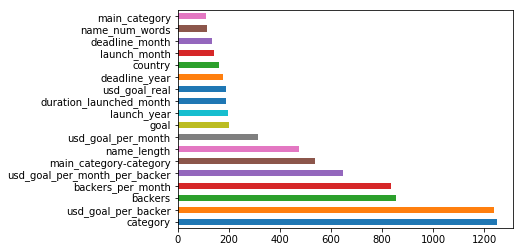

In [105]:
print('Following is the feature importance bar plot:')
(pd.Series(result_model.feature_importances_, index=X_lgbm.columns)
   .nlargest(40)
   .plot(kind='barh')) 

In [106]:
y_pred = result_model.predict(X_test, num_iteration=result_model.best_iteration_)
y_pred_proba = result_model.predict_proba(X_test, num_iteration=result_model.best_iteration_)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Test Log_loss:",metrics.log_loss(y_test, y_pred_proba))

Test Accuracy: 0.8618826263800117
Test Log_loss: 0.32959245838126167


## 7.2 Summary of Final LightGBM Model
- Train, validation and test set accuracy and log-losses are (~87%, 0.298), (~86%, 0.335) and (~86%, 0.330)
- The backer, usd_goal_real and the category column were the most important features to determine if the kickerstarter project failed, succeeded or surged. The top 5 important features of the model are: category, usd_goal_per_backer, backers, backers_per_month and usd_goal_per_month_per_backer. 
- The model does not overfit as the evaluation metrics do not differ much from each other

# 8.0 Improvements

- To possibly increase accuracy, model could have been split and trained by category, year (launch_year or deadline year), duration of kickstarter in months and usd_goal_real
    - For model to be split and trained by usd_goal_real: split rows into <=25 percentile usd_goal_real, split rows into >25 percentile and <75 percentile usd_goal_real and split rows into >75% percentile usd_goal_real
    - Then train individual models and evaluate
    
- Clean up the code more and use functions so I do not have to have repeated cells anymore
    
- Benchmarking took too long using K-NN (~1 hours to run the code). Could replace with the following:
    - Sample the original dataset instead of benchmarking on the entire dataset
    - Benchmarking can be done by mapping a predictions to a simple function using the distributions of the dataset. 
        - Eg: Derive a random number for each row in the dataset. If the random number is between [0,60], [61,87] and [87,100], predict classes failed, succeeded and surged.
        
- Due to time constraint, I trained the k-nn model based on accuracy instead of log_loss by mistake. Should not make too much of a difference but I should have trained using log_loss to keep it consistent.

- With respect to EDA
    - Do EDA for all features and see classification for all features
        - eg. Number of failed, succeeded and surged for main_category "Music"
    - Do some correlation analysis between numerical features to get a better idea of the dataset
    - Change all bar plots and histograms to display the class variables using color
    - Overall more in-depth EDA

  


